In [1]:
import os 
import random
import numpy as np

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import copy
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [69]:
main_dir = "/Users/devin/Documents/FYP/HAR-ZSL-XAI"
data_dir = os.path.join(main_dir,"sequence_data")
epoch_vids = os.path.join(main_dir,"epoch_vids")
models_saves = os.path.join(main_dir,"model_saves")
test_vids = os.path.join(main_dir,"test_vids")
class_names = os.listdir(data_dir)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 1-train_ratio - val_ratio
batch_size = 32

os.makedirs(epoch_vids,exist_ok=True)

In [3]:
def classname_id(class_name_list):
    id2classname = {k:v for k, v in zip(list(range(len(class_name_list))),class_name_list)}
    classname2id = {v:k for k, v in id2classname.items()}
    return id2classname, classname2id

In [4]:
class_names = os.listdir(os.path.join(main_dir,"data","pose_data"))

In [5]:
id2clsname, clsname2id = classname_id(class_names)

In [6]:
train_file_list = []
val_file_list = []
test_file_list = []

file_list = [os.path.join(data_dir,x) for x in os.listdir(data_dir)]

random.shuffle(file_list)
num_list = len(file_list)

train_range = [0,int(num_list*train_ratio)]
val_range = [int(num_list*train_ratio),int(num_list*(train_ratio+val_ratio))]
test_range = [int(num_list*(train_ratio+val_ratio)),num_list-1]

train_file_list += file_list[train_range[0]:train_range[1]]
val_file_list += file_list[val_range[0]:val_range[1]]
test_file_list += file_list[test_range[0]:test_range[1]]

In [7]:
len(train_file_list),len(val_file_list),len(test_file_list)

(12357, 2648, 2647)

In [8]:
train_file_list = train_file_list[:(len(train_file_list)//batch_size)*batch_size]
val_file_list = val_file_list[:(len(val_file_list)//batch_size)*batch_size]
test_file_list = test_file_list[:(len(test_file_list)//batch_size)*batch_size]

In [9]:
len(train_file_list),len(val_file_list),len(test_file_list)

(12352, 2624, 2624)

In [10]:
class SkeletonDataset(Dataset):
    def __init__(self, file_list,class2id, transform=None, 
                 target_transform=None,active_locations=[11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28], file_name=False):
        self.file_list = file_list
        self.transform = transform
        self.class2id = class2id
        self.target_transform = target_transform
        self.active_locations = active_locations
        self.file_name = file_name

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        a_file = np.load(self.file_list[idx])
        action_type = self.file_list[idx].strip().split("/")[-1].split("_cls_")[0]
        coords, vid_size = a_file["coords"],a_file["video_size"]
        coords = coords[:,self.active_locations,:]
        
        shape = coords.shape
        
        coords = torch.from_numpy(coords).float()
        
        coords = torch.reshape(coords, (shape[0], shape[1]*shape[2]))
        label = torch.clone(coords)
        
        if self.transform:
            coords = self.transform(coords)
        if self.target_transform:
            label = self.target_transform(coords)

        return coords, label, self.class2id[action_type],a_file["video_size"]

In [11]:
train_data = SkeletonDataset(train_file_list,clsname2id)
val_data = SkeletonDataset(val_file_list,clsname2id)
test_data = SkeletonDataset(test_file_list,clsname2id)

In [12]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [13]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [14]:
encoder = BiLSTMEncoder(50,36,512,linear_filters=[128,256,512],embedding_size = 256)
decoder = BiLSTMDecoder(50,36,512,linear_filters=[128,256,512],embedding_size = 256)

bilstm_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers = 1,bidirectional=True,batch_size=32)

In [15]:
lstm_out, embedding = encoder(torch.randn((32,50,36)))

In [16]:
embedding.shape

torch.Size([32, 256])

In [17]:
decoder_out = decoder(embedding)

In [18]:
model_out,embedding = bilstm_model(torch.randn((32,50,36)))

In [19]:
model_out.shape

torch.Size([32, 50, 36])

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gen_skeleton(frame, connections, height, width):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles 
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines 
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3



def gen_video(points, save_file, frame_h, frame_w):
    # make 3D if points are flatten 
    if len(points.shape) == 2:
        fts = points.shape[1]
        x_cds = list(range(0, fts, 3))
        y_cds = list(range(1, fts, 3))
        z_cds = list(range(2, fts, 3))
        points = np.transpose(np.array([points[:, x_cds], points[:, y_cds], points[:, z_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file, 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    # mapping_list = [(11, 12), (11, 13), (13, 15), (12, 14), (14, 16), (12, 24), (11, 23), (23, 24), (24, 26), (26, 28), (23, 25), (25, 27)]
    mapping_list = [(0, 1), (1, 3), (3, 5), (0, 2), (2, 4), (0, 6), (1, 7), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11)]
    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, mapping_list, frame_h, frame_w)
        result.write(skel_image)

    result.release()

def gen_random_video(model,dataset,epoch,batch_size,name="tcn"):
    ind = random.randint(0,len(dataset)-1)
    batch_sel = random.randint(0,batch_size-1)

    in_seq,tar_seq,action,vid_size = dataset[ind]
    pred_seq, _ = model(in_seq.repeat(batch_size,1,1))

    os.makedirs(f"{epoch_vids}/{name}/{epoch}",exist_ok=True)
    gen_video(pred_seq[batch_sel].squeeze().detach().numpy(),f"{epoch_vids}/{name}/{epoch}/pred.mp4",int(vid_size[0]),int(vid_size[1]))
    gen_video(in_seq.detach().numpy(),f"{epoch_vids}/{name}/{epoch}/true.mp4",int(vid_size[0]),int(vid_size[1]))

def save_model(model,model_name,unique_name):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save(model.state_dict(), f"{PATH}/{unique_name}.pt")

In [22]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    std_loss = nn.L1Loss(reduction='mean').to(device)
    #contrastive_loss = SupConLoss(contrast_mode="one").to(device)
    history = dict(train=[], val=[])
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for in_seq,tar_seq,action,vid_size in tqdm(train_dataset):
            optimizer.zero_grad()
            
            in_seq = in_seq.to(device)
            tar_seq = tar_seq.to(device)
            seq_pred,_  = model(in_seq)
            
            loss = std_loss(seq_pred, tar_seq)
            #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
            #print(contrastive_loss(embed,labels=sample_label.view(-1)))

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for in_seq,tar_seq,action,vid_size in val_dataset:

                in_seq = in_seq.to(device)
                tar_seq = tar_seq.to(device)
                seq_pred,_  = model(in_seq)

                loss = std_loss(seq_pred, tar_seq)
                #loss += 0.5*contrastive_loss(embed,labels=sample_label.view(-1))
                val_losses.append(loss.item())

            gen_random_video(model,val_data,epoch,batch_size,name="bilstm1")

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [23]:
model, history = train_model(
  bilstm_model, 
  train_dl, 
  val_dl, 
  n_epochs=100
)

100%|██████████| 386/386 [02:31<00:00,  2.55it/s]


Epoch 1: train loss 0.15753607947977713 val loss 0.1137847874949618


100%|██████████| 386/386 [02:39<00:00,  2.43it/s]


Epoch 2: train loss 0.10102693381395983 val loss 0.09277717160379015


100%|██████████| 386/386 [02:40<00:00,  2.40it/s]


Epoch 3: train loss 0.08587888018300496 val loss 0.08270809408731578


100%|██████████| 386/386 [02:38<00:00,  2.43it/s]


Epoch 4: train loss 0.07840399613961037 val loss 0.07579490678702913


100%|██████████| 386/386 [02:45<00:00,  2.33it/s]


Epoch 5: train loss 0.07370840736853027 val loss 0.07542654426722992


100%|██████████| 386/386 [02:41<00:00,  2.39it/s]


Epoch 6: train loss 0.06917788832414644 val loss 0.07048202392349882


100%|██████████| 386/386 [02:42<00:00,  2.38it/s]


Epoch 7: train loss 0.06647892624448618 val loss 0.06868239537608332


100%|██████████| 386/386 [1:39:19<00:00, 15.44s/it]   


Epoch 8: train loss 0.06397333033768933 val loss 0.06523441927643811


100%|██████████| 386/386 [6:31:25<00:00, 60.84s/it]    


Epoch 9: train loss 0.06239640267826424 val loss 0.06164853692781634


100%|██████████| 386/386 [1:19:46<00:00, 12.40s/it]   


Epoch 10: train loss 0.06074700938836898 val loss 0.06191195270455465


100%|██████████| 386/386 [03:10<00:00,  2.02it/s]


Epoch 11: train loss 0.0598705125480427 val loss 0.06208979515585958


100%|██████████| 386/386 [03:06<00:00,  2.07it/s]


Epoch 12: train loss 0.0593527751091694 val loss 0.06096389181003338


100%|██████████| 386/386 [03:06<00:00,  2.07it/s]


Epoch 13: train loss 0.057265477872651474 val loss 0.058387718049854764


100%|██████████| 386/386 [03:03<00:00,  2.10it/s]


Epoch 14: train loss 0.05635486337612021 val loss 0.05651584394821307


100%|██████████| 386/386 [03:09<00:00,  2.04it/s]


Epoch 15: train loss 0.05581821334292543 val loss 0.05567861121238732


100%|██████████| 386/386 [03:04<00:00,  2.09it/s]


Epoch 16: train loss 0.05379443386946008 val loss 0.053718200226019065


100%|██████████| 386/386 [03:03<00:00,  2.10it/s]


Epoch 17: train loss 0.053071419655350206 val loss 0.05262203223821593


100%|██████████| 386/386 [03:09<00:00,  2.04it/s]


Epoch 18: train loss 0.05182030378150816 val loss 0.051460421348853806


100%|██████████| 386/386 [02:56<00:00,  2.19it/s]


Epoch 19: train loss 0.05100640961466058 val loss 0.05112006288112664


100%|██████████| 386/386 [02:48<00:00,  2.29it/s]


Epoch 20: train loss 0.05036268030037534 val loss 0.053099338873857406


100%|██████████| 386/386 [02:49<00:00,  2.28it/s]


Epoch 21: train loss 0.04992298293530632 val loss 0.05141391786860257


100%|██████████| 386/386 [02:48<00:00,  2.29it/s]


Epoch 22: train loss 0.04942592444776562 val loss 0.0492572445058968


100%|██████████| 386/386 [02:47<00:00,  2.30it/s]


Epoch 23: train loss 0.04775886427746227 val loss 0.048511124147874556


100%|██████████| 386/386 [02:48<00:00,  2.29it/s]


Epoch 24: train loss 0.04755596160271007 val loss 0.04802512836347266


100%|██████████| 386/386 [02:49<00:00,  2.28it/s]


Epoch 25: train loss 0.046634487344502165 val loss 0.0494274344386124


100%|██████████| 386/386 [02:50<00:00,  2.27it/s]


Epoch 26: train loss 0.04597136147629103 val loss 0.046370026451058505


100%|██████████| 386/386 [02:49<00:00,  2.28it/s]


Epoch 27: train loss 0.04615105676990717 val loss 0.04741731485942515


100%|██████████| 386/386 [02:53<00:00,  2.23it/s]


Epoch 28: train loss 0.04536103850973702 val loss 0.04626523312635538


100%|██████████| 386/386 [03:04<00:00,  2.09it/s]


Epoch 29: train loss 0.044951309609212405 val loss 0.04651348397317456


100%|██████████| 386/386 [03:05<00:00,  2.08it/s]


Epoch 30: train loss 0.044593227728043194 val loss 0.046032499885413705


100%|██████████| 386/386 [03:05<00:00,  2.08it/s]


Epoch 31: train loss 0.04414040171613656 val loss 0.0463672181273379


100%|██████████| 386/386 [03:01<00:00,  2.13it/s]


Epoch 32: train loss 0.04366014722174931 val loss 0.045251561873933165


100%|██████████| 386/386 [03:02<00:00,  2.12it/s]


Epoch 33: train loss 0.043816399668859696 val loss 0.044126317722768316


100%|██████████| 386/386 [02:59<00:00,  2.15it/s]


Epoch 34: train loss 0.04305617907928988 val loss 0.04481700957730049


100%|██████████| 386/386 [02:56<00:00,  2.18it/s]


Epoch 35: train loss 0.042809423773399906 val loss 0.04551462324835905


100%|██████████| 386/386 [02:56<00:00,  2.19it/s]


Epoch 36: train loss 0.04252957837376261 val loss 0.04491607831200448


100%|██████████| 386/386 [02:58<00:00,  2.16it/s]


Epoch 37: train loss 0.042435933493193564 val loss 0.04710741818132924


100%|██████████| 386/386 [02:50<00:00,  2.27it/s]


Epoch 38: train loss 0.04176656959742462 val loss 0.043946889569846596


100%|██████████| 386/386 [02:56<00:00,  2.19it/s]


Epoch 39: train loss 0.0421826644014046 val loss 0.04450270847031256


100%|██████████| 386/386 [02:57<00:00,  2.18it/s]


Epoch 40: train loss 0.041191237819395536 val loss 0.04233195891649258


100%|██████████| 386/386 [02:58<00:00,  2.16it/s]


Epoch 41: train loss 0.04080299536547976 val loss 0.042717497659529126


100%|██████████| 386/386 [03:03<00:00,  2.11it/s]


Epoch 42: train loss 0.04062712067072256 val loss 0.04409461359425289


100%|██████████| 386/386 [03:00<00:00,  2.13it/s]


Epoch 43: train loss 0.040481629699391404 val loss 0.041540809611721734


100%|██████████| 386/386 [02:56<00:00,  2.19it/s]


Epoch 44: train loss 0.04011897434881005 val loss 0.04138167447796682


100%|██████████| 386/386 [03:00<00:00,  2.14it/s]


Epoch 45: train loss 0.03959120346783356 val loss 0.04097650831610691


100%|██████████| 386/386 [03:02<00:00,  2.12it/s]


Epoch 46: train loss 0.03949731845080544 val loss 0.04004940113461599


100%|██████████| 386/386 [03:18<00:00,  1.95it/s]


Epoch 47: train loss 0.039680450565997186 val loss 0.042402178049087524


100%|██████████| 386/386 [03:27<00:00,  1.86it/s]


Epoch 48: train loss 0.03941505300990967 val loss 0.040366380043872975


100%|██████████| 386/386 [03:24<00:00,  1.88it/s]


Epoch 49: train loss 0.038796783960545 val loss 0.039951262495866634


100%|██████████| 386/386 [03:22<00:00,  1.91it/s]


Epoch 50: train loss 0.0387884684756321 val loss 0.039299002507837806


100%|██████████| 386/386 [03:17<00:00,  1.95it/s]


Epoch 51: train loss 0.03825010610696102 val loss 0.039817546698741796


100%|██████████| 386/386 [03:18<00:00,  1.94it/s]


Epoch 52: train loss 0.03798236518403409 val loss 0.038583444454139325


100%|██████████| 386/386 [03:22<00:00,  1.91it/s]


Epoch 53: train loss 0.03810316785552341 val loss 0.04070419909023657


100%|██████████| 386/386 [03:18<00:00,  1.94it/s]


Epoch 54: train loss 0.038014171287957865 val loss 0.041475062008674554


100%|██████████| 386/386 [03:20<00:00,  1.93it/s]


Epoch 55: train loss 0.038188083671573836 val loss 0.040690873863130084


100%|██████████| 386/386 [03:21<00:00,  1.92it/s]


Epoch 56: train loss 0.037715564805222916 val loss 0.04150302421937629


100%|██████████| 386/386 [03:23<00:00,  1.90it/s]


Epoch 57: train loss 0.03728744175304403 val loss 0.03955881679203452


100%|██████████| 386/386 [03:24<00:00,  1.89it/s]


Epoch 58: train loss 0.03702583013903446 val loss 0.03828782910799108


100%|██████████| 386/386 [03:11<00:00,  2.01it/s]


Epoch 59: train loss 0.03681425890195246 val loss 0.03808958137907633


100%|██████████| 386/386 [02:48<00:00,  2.29it/s]


Epoch 60: train loss 0.036831088827372835 val loss 0.039202050237757406


100%|██████████| 386/386 [02:49<00:00,  2.28it/s]


Epoch 61: train loss 0.03656678195135581 val loss 0.037756738979823706


100%|██████████| 386/386 [02:45<00:00,  2.33it/s]


Epoch 62: train loss 0.036431850286422617 val loss 0.04035068753107292


100%|██████████| 386/386 [02:46<00:00,  2.32it/s]


Epoch 63: train loss 0.036718754343920114 val loss 0.038475729979392956


100%|██████████| 386/386 [02:43<00:00,  2.36it/s]


Epoch 64: train loss 0.03668346198594169 val loss 0.03777421965468221


100%|██████████| 386/386 [02:42<00:00,  2.37it/s]


Epoch 65: train loss 0.03584066290562789 val loss 0.036432324976819315


100%|██████████| 386/386 [02:42<00:00,  2.37it/s]


Epoch 66: train loss 0.035650312895717705 val loss 0.03736845837769712


100%|██████████| 386/386 [02:42<00:00,  2.38it/s]


Epoch 67: train loss 0.035811830606369464 val loss 0.03781740296995494


100%|██████████| 386/386 [02:42<00:00,  2.37it/s]


Epoch 68: train loss 0.03601440865006008 val loss 0.03686181971485295


100%|██████████| 386/386 [02:43<00:00,  2.36it/s]


Epoch 69: train loss 0.03592850368740182 val loss 0.03604682532661572


100%|██████████| 386/386 [02:42<00:00,  2.38it/s]


Epoch 70: train loss 0.03570174403160502 val loss 0.038301049572665516


100%|██████████| 386/386 [02:42<00:00,  2.38it/s]


Epoch 71: train loss 0.03561448845336783 val loss 0.03791335906560828


100%|██████████| 386/386 [02:42<00:00,  2.38it/s]


Epoch 72: train loss 0.03533527432154343 val loss 0.0369637622157248


100%|██████████| 386/386 [02:42<00:00,  2.38it/s]


Epoch 73: train loss 0.035258700487256975 val loss 0.03671959281058573


100%|██████████| 386/386 [02:43<00:00,  2.36it/s]


Epoch 74: train loss 0.035039078347732365 val loss 0.03676771763257864


100%|██████████| 386/386 [02:44<00:00,  2.35it/s]


Epoch 75: train loss 0.034859912180452764 val loss 0.03710628005607826


100%|██████████| 386/386 [02:45<00:00,  2.34it/s]


Epoch 76: train loss 0.035075824760827067 val loss 0.03652670852294782


100%|██████████| 386/386 [02:44<00:00,  2.34it/s]


Epoch 77: train loss 0.034757033960382246 val loss 0.03582209144241926


100%|██████████| 386/386 [02:49<00:00,  2.27it/s]


Epoch 78: train loss 0.034687980459375704 val loss 0.03634518702946058


100%|██████████| 386/386 [02:50<00:00,  2.26it/s]


Epoch 79: train loss 0.03477149076007036 val loss 0.03664633016124731


100%|██████████| 386/386 [02:50<00:00,  2.26it/s]


Epoch 80: train loss 0.03410937714298772 val loss 0.03543364526931106


100%|██████████| 386/386 [02:45<00:00,  2.33it/s]


Epoch 81: train loss 0.03428141072566182 val loss 0.03617664967186567


100%|██████████| 386/386 [02:44<00:00,  2.35it/s]


Epoch 82: train loss 0.03409542817468007 val loss 0.034995540794802875


100%|██████████| 386/386 [02:46<00:00,  2.32it/s]


Epoch 83: train loss 0.0341447756234846 val loss 0.035820390597530984


100%|██████████| 386/386 [02:46<00:00,  2.31it/s]


Epoch 84: train loss 0.03430713031807712 val loss 0.036367834636532675


100%|██████████| 386/386 [02:48<00:00,  2.29it/s]


Epoch 85: train loss 0.03392351530202775 val loss 0.03537774492600342


100%|██████████| 386/386 [02:48<00:00,  2.29it/s]


Epoch 86: train loss 0.03378977743821904 val loss 0.03559036259880153


100%|██████████| 386/386 [02:48<00:00,  2.29it/s]


Epoch 87: train loss 0.03386280325197957 val loss 0.0353084961179553


100%|██████████| 386/386 [02:44<00:00,  2.35it/s]


Epoch 88: train loss 0.033537808820180634 val loss 0.03557468700881412


100%|██████████| 386/386 [02:38<00:00,  2.43it/s]


Epoch 89: train loss 0.03338221376134479 val loss 0.035345310118140245


100%|██████████| 386/386 [02:41<00:00,  2.39it/s]


Epoch 90: train loss 0.03343286836722509 val loss 0.03627018055810434


100%|██████████| 386/386 [33:43<00:00,  5.24s/it]    


Epoch 91: train loss 0.033690475482358526 val loss 0.035228370098260846


100%|██████████| 386/386 [34:14<00:00,  5.32s/it]    


Epoch 92: train loss 0.033115273602113825 val loss 0.03569998769316732


100%|██████████| 386/386 [51:56<00:00,  8.07s/it]    


Epoch 93: train loss 0.033487281573868787 val loss 0.03419382166026569


100%|██████████| 386/386 [02:35<00:00,  2.48it/s]


Epoch 94: train loss 0.03291087467319916 val loss 0.034929171068275845


100%|██████████| 386/386 [02:37<00:00,  2.45it/s]


Epoch 95: train loss 0.03326595428887118 val loss 0.03408677476208385


100%|██████████| 386/386 [02:32<00:00,  2.53it/s]


Epoch 96: train loss 0.032926207461389544 val loss 0.03454345664600047


100%|██████████| 386/386 [02:34<00:00,  2.50it/s]


Epoch 97: train loss 0.03300447848871582 val loss 0.03601966493922036


100%|██████████| 386/386 [02:33<00:00,  2.52it/s]


Epoch 98: train loss 0.03334748162526078 val loss 0.03409375538822354


100%|██████████| 386/386 [02:33<00:00,  2.51it/s]


Epoch 99: train loss 0.032883943574879455 val loss 0.034028611304919895


100%|██████████| 386/386 [02:32<00:00,  2.52it/s]


Epoch 100: train loss 0.03288075692681451 val loss 0.0343844953742696


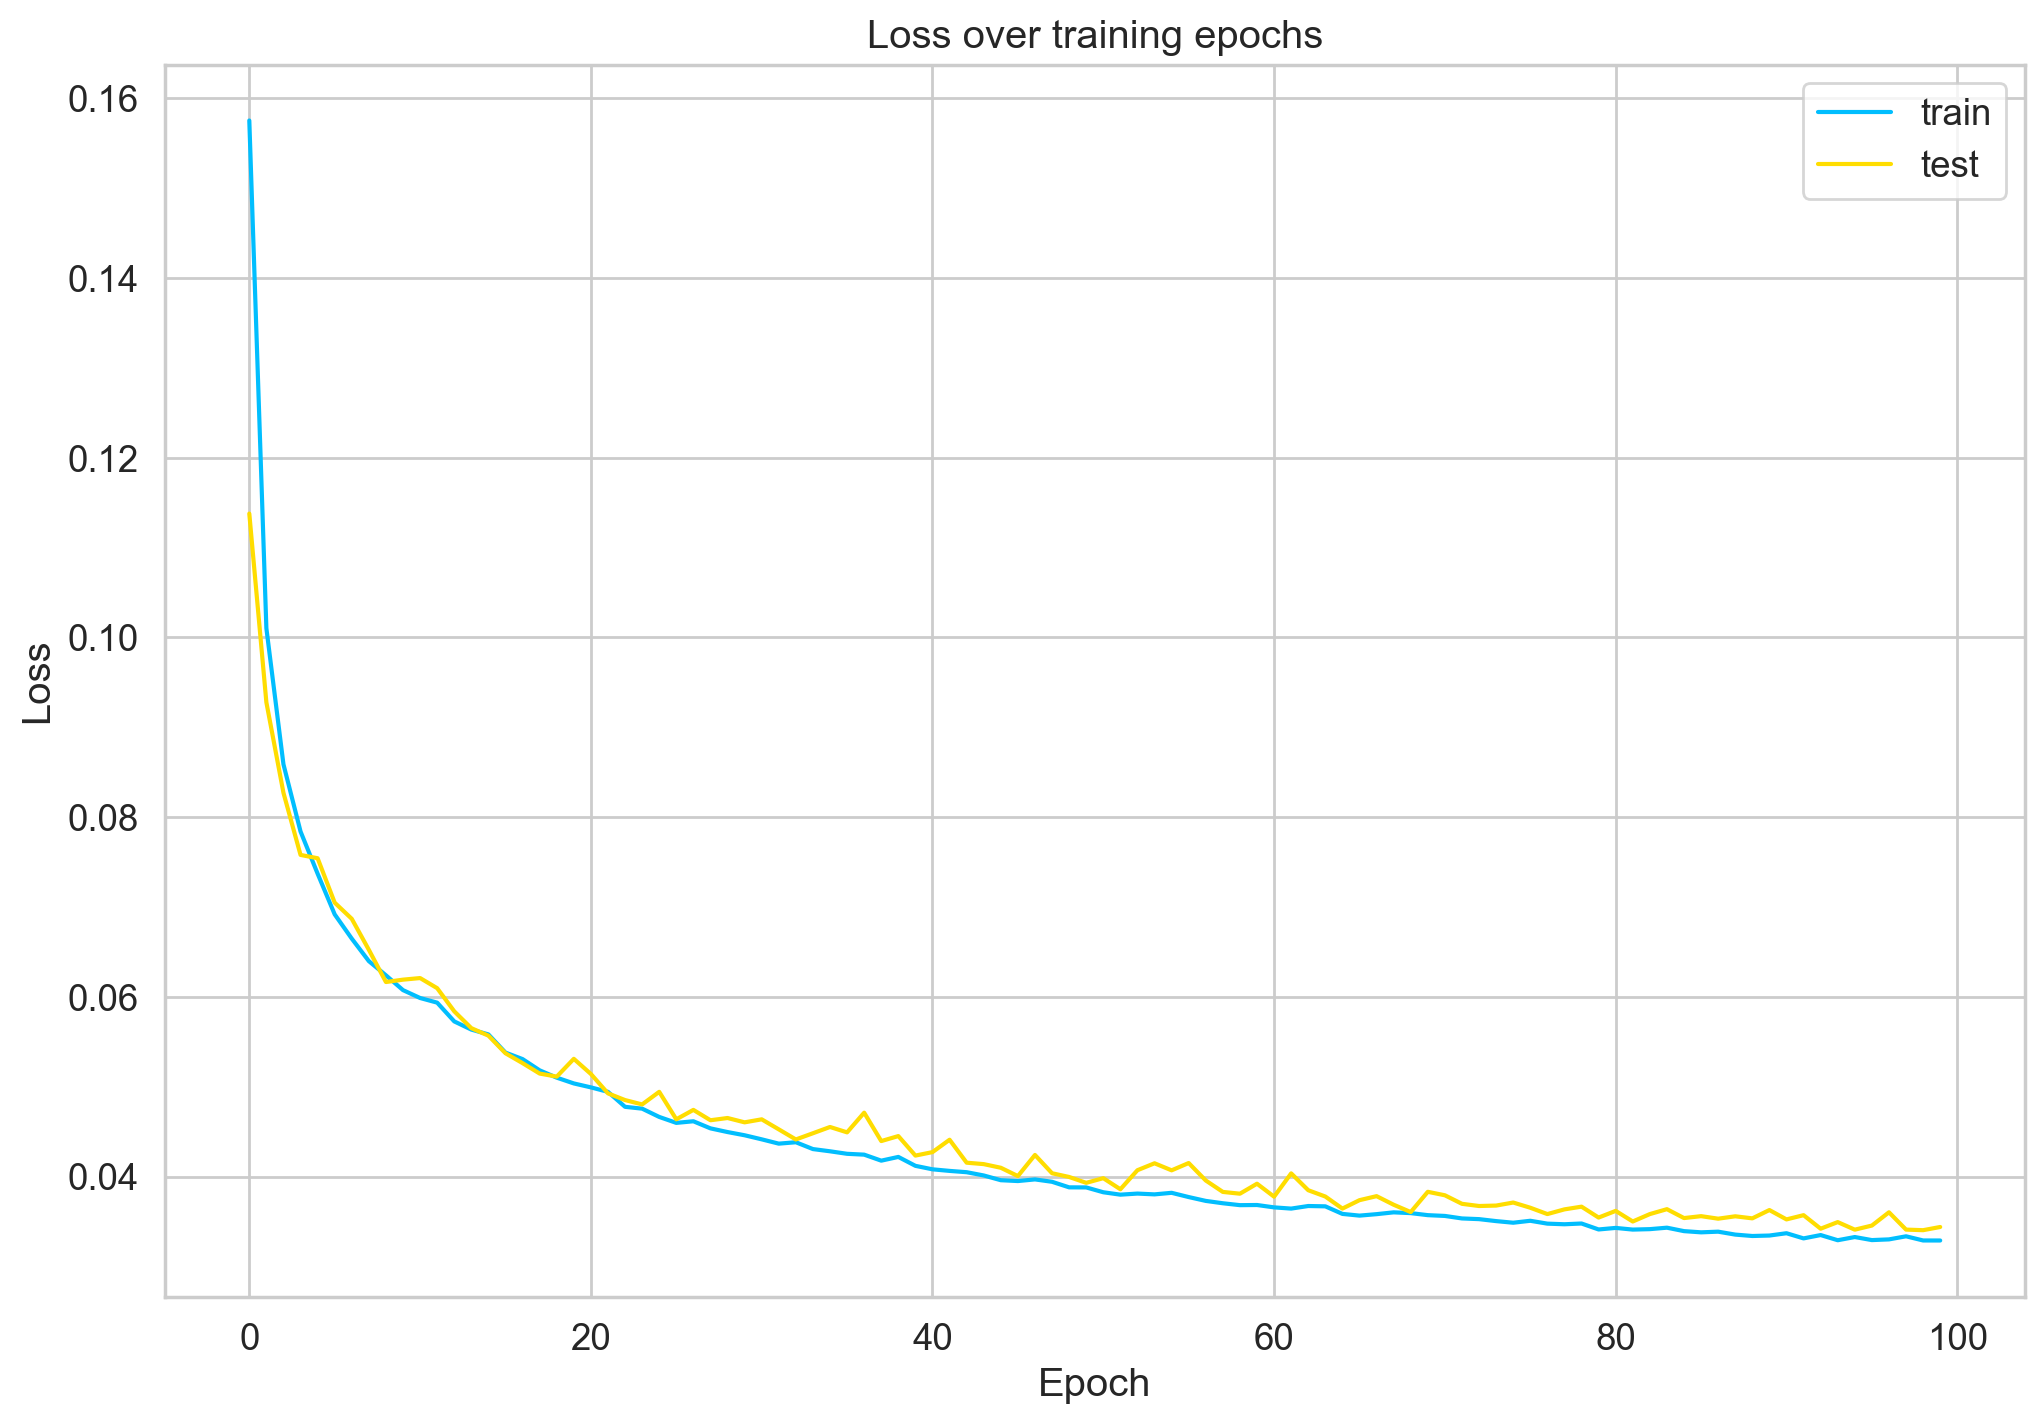

In [24]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [30]:
embedding_list = {}
output_list = {}
with torch.no_grad():
    for in_seq,tar_seq,action,vid_size in tqdm(test_dl):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for seq,emb,action in zip(seq_pred.unbind(0),embedding.unbind(0),action.unbind(0)):
                try:
                    if len(embedding_list[int(action)])<=50:
                        embedding_list[int(action)].append(emb)
                        output_list[int(action)].append(seq)
                except KeyError:
                    embedding_list[int(action)] = [emb]
                    output_list[int(action)] = [emb]

        
            
        
        #embedding_list[]

100%|██████████| 82/82 [00:12<00:00,  6.55it/s]


In [46]:
def draw_heatmaps(arr_list,nrows=5,ncols=2):
    ran_list = random.sample(arr_list,ncols*nrows)
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, sharex=True)
    for i in range(nrows):
        for j in range(ncols):
            #print(i*ncols+j,len(ran_list))
            ax[i,j].imshow(ran_list[i*ncols+j].detach().numpy()[np.newaxis,:], cmap="plasma", aspect="auto")

    plt.tight_layout()
    plt.show()

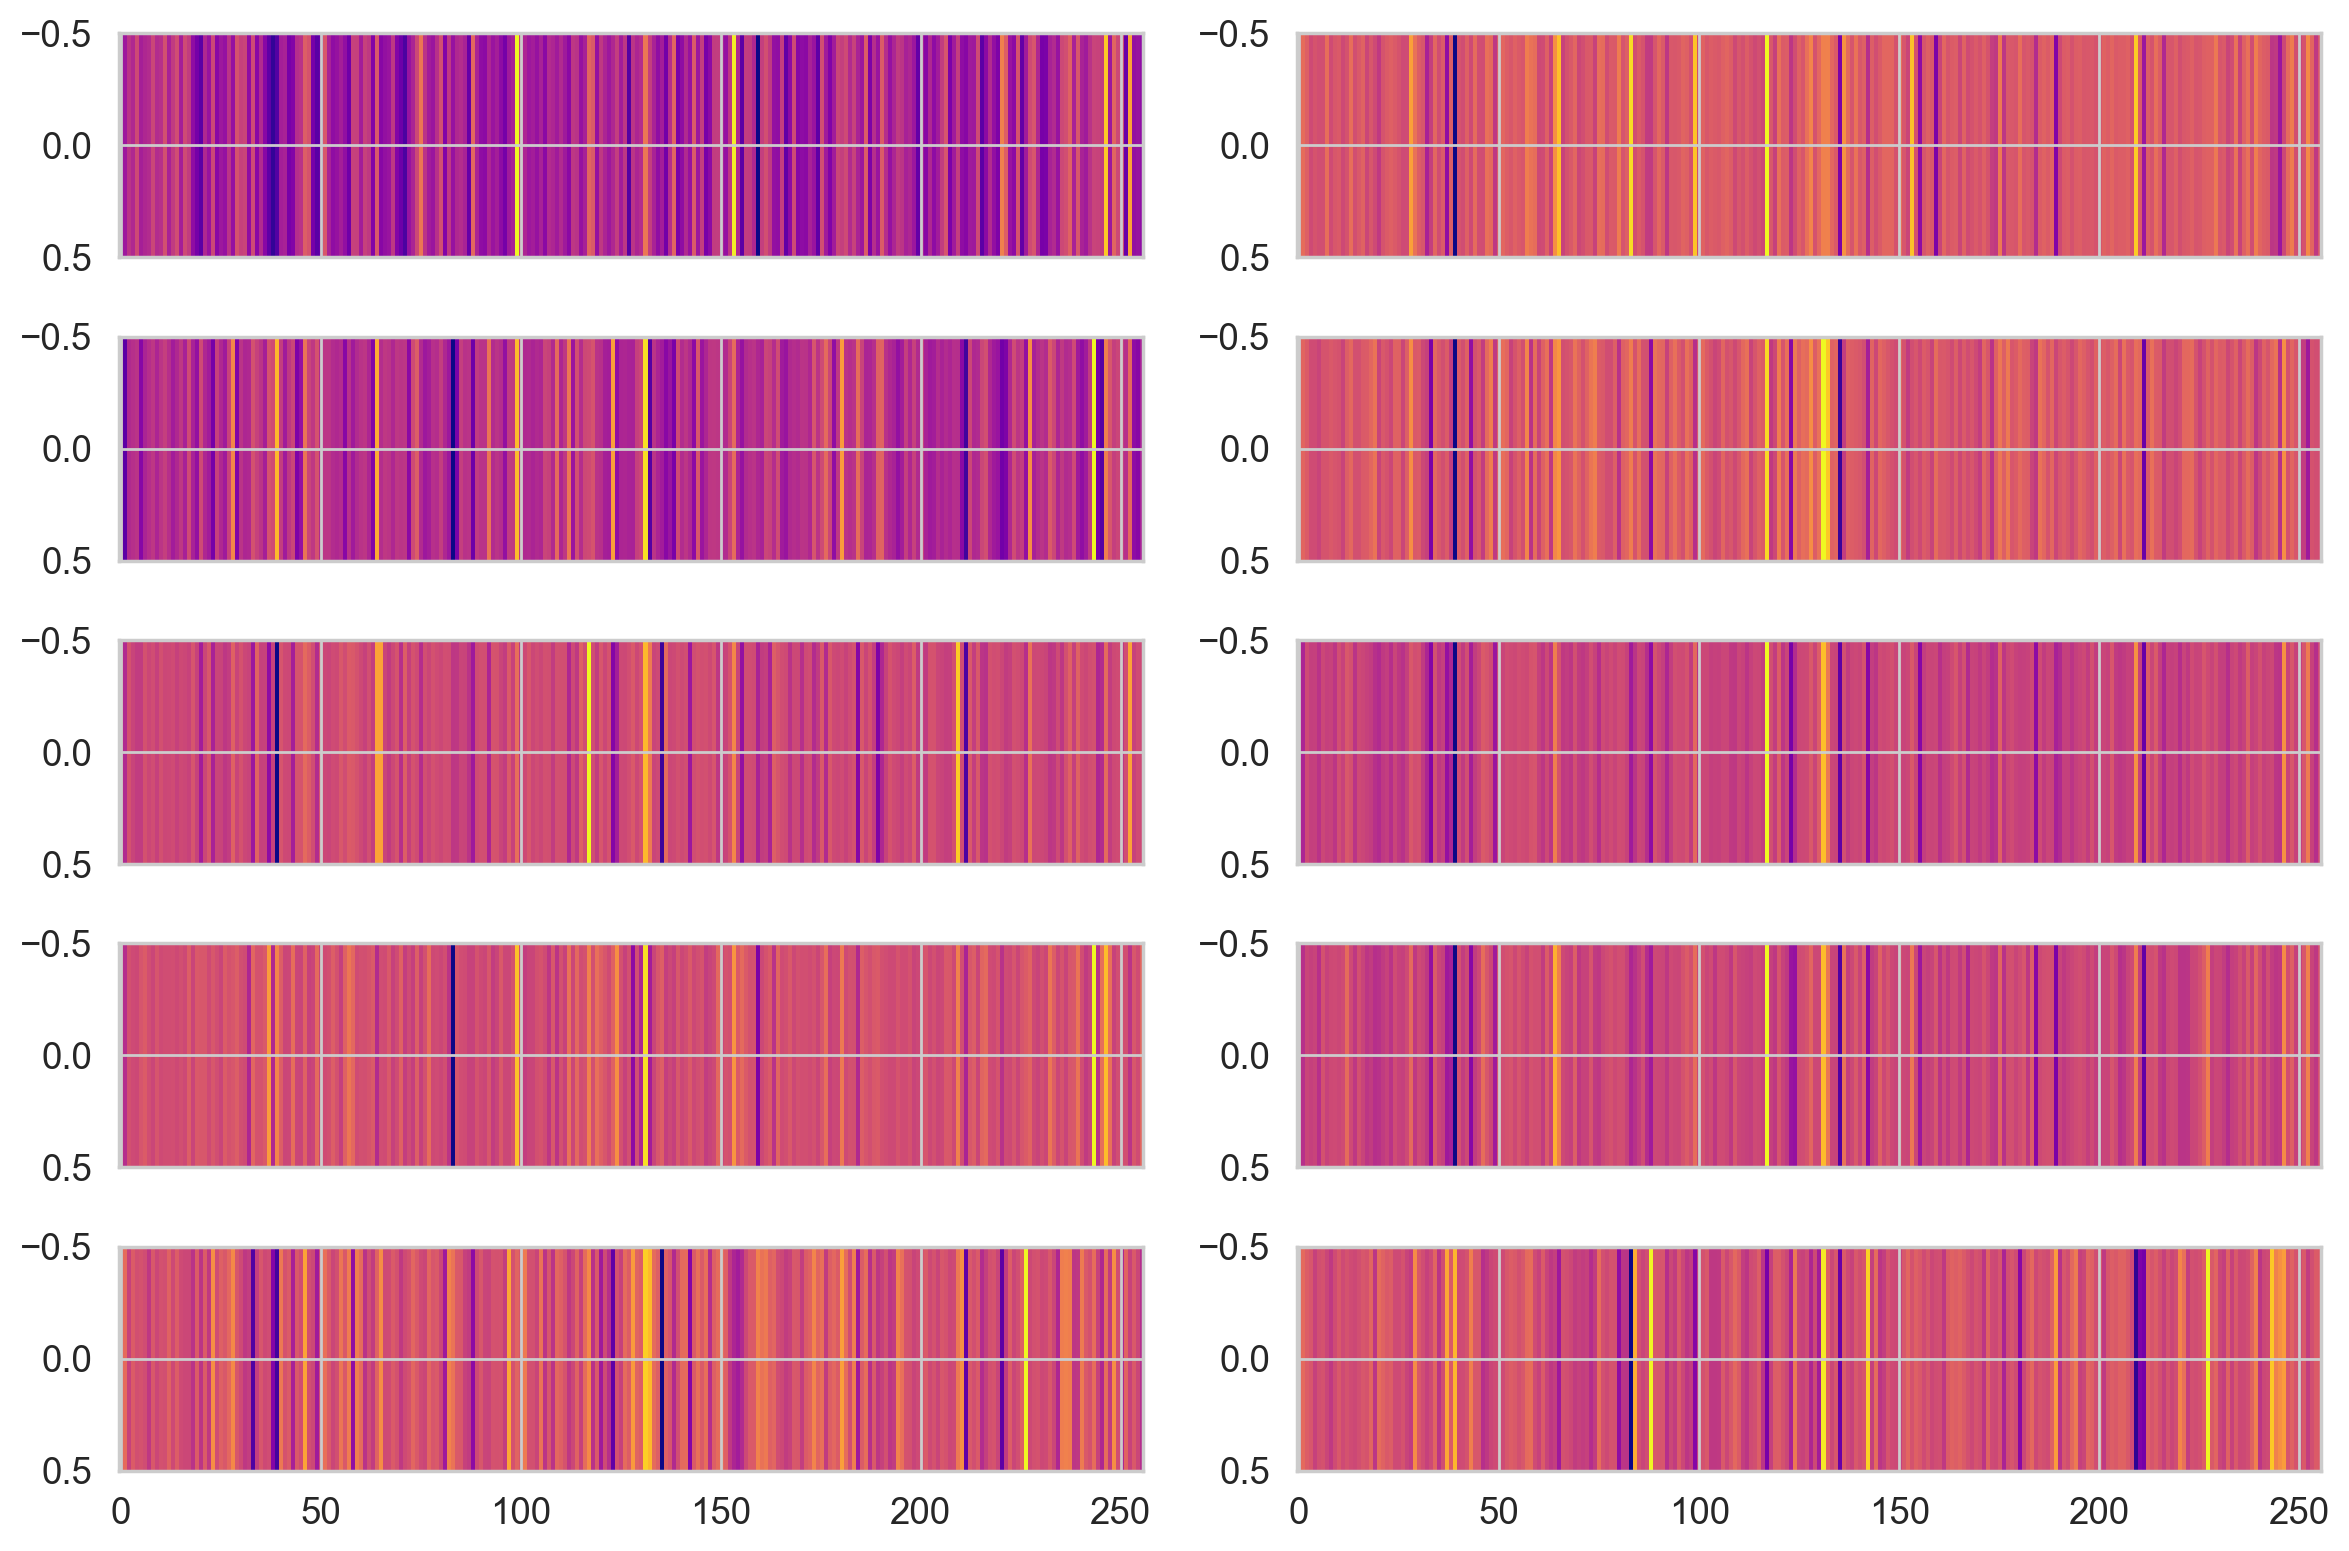

In [47]:
draw_heatmaps(embedding_list[19])

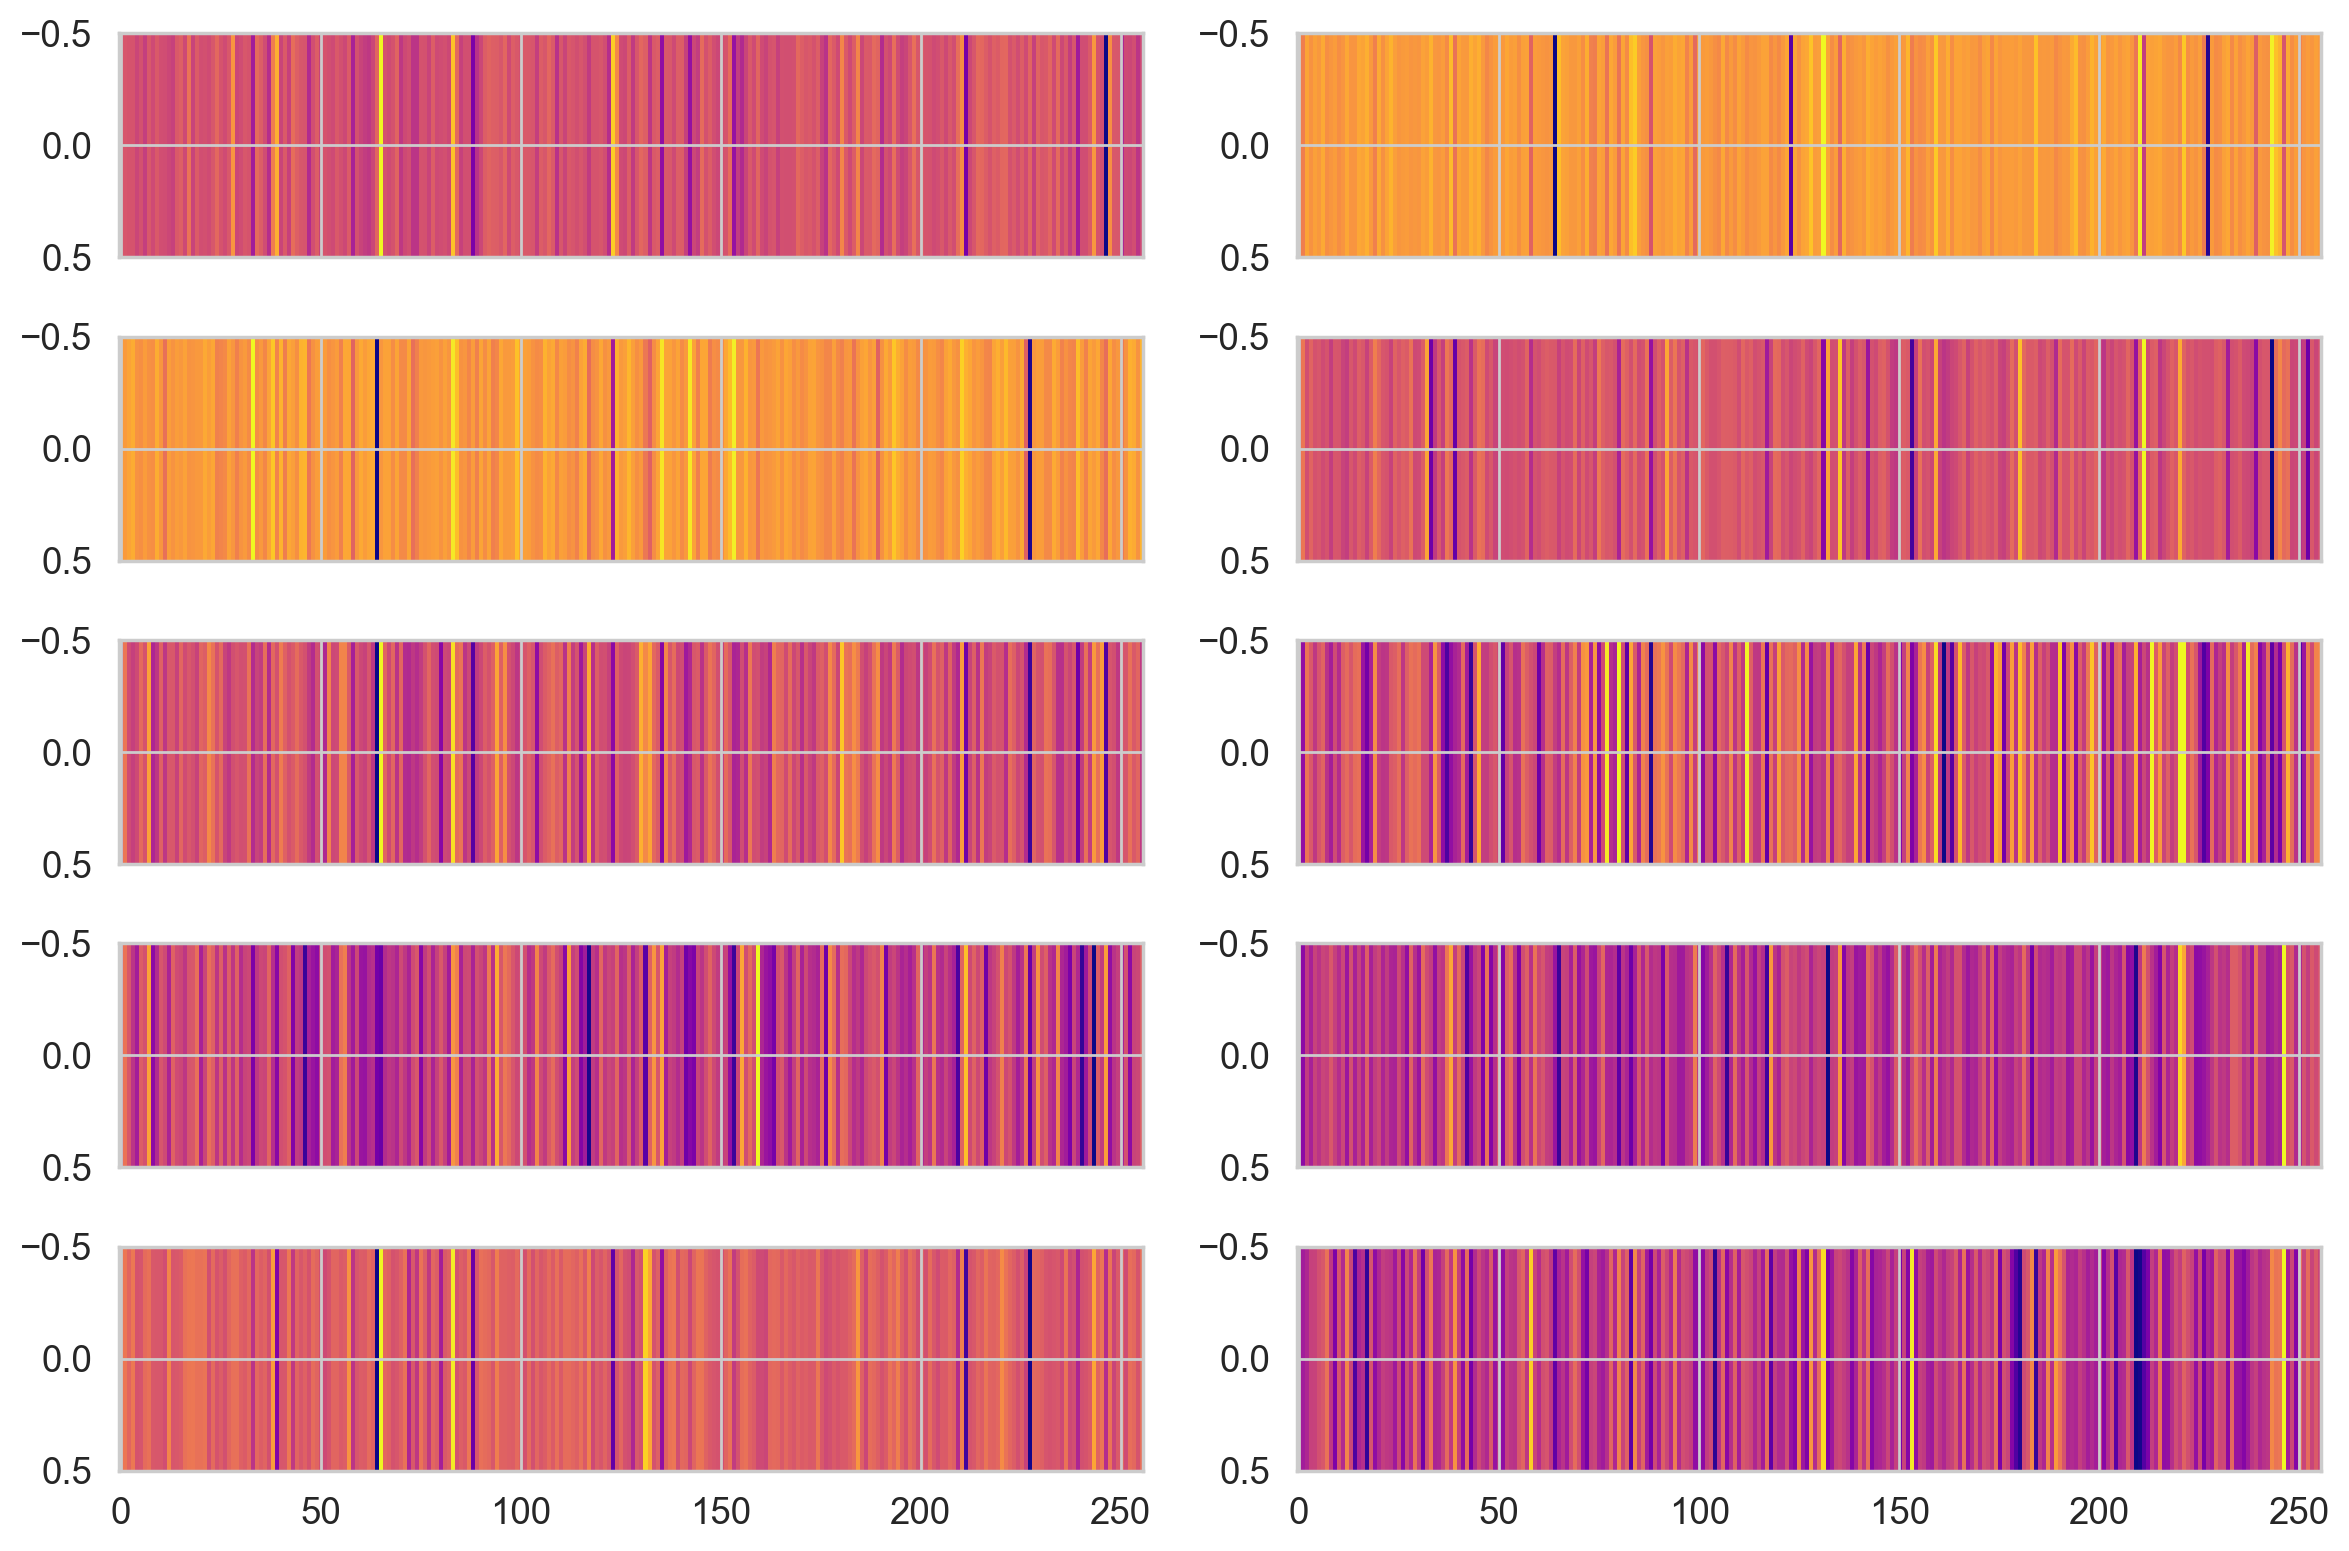

In [49]:
draw_heatmaps(embedding_list[22])

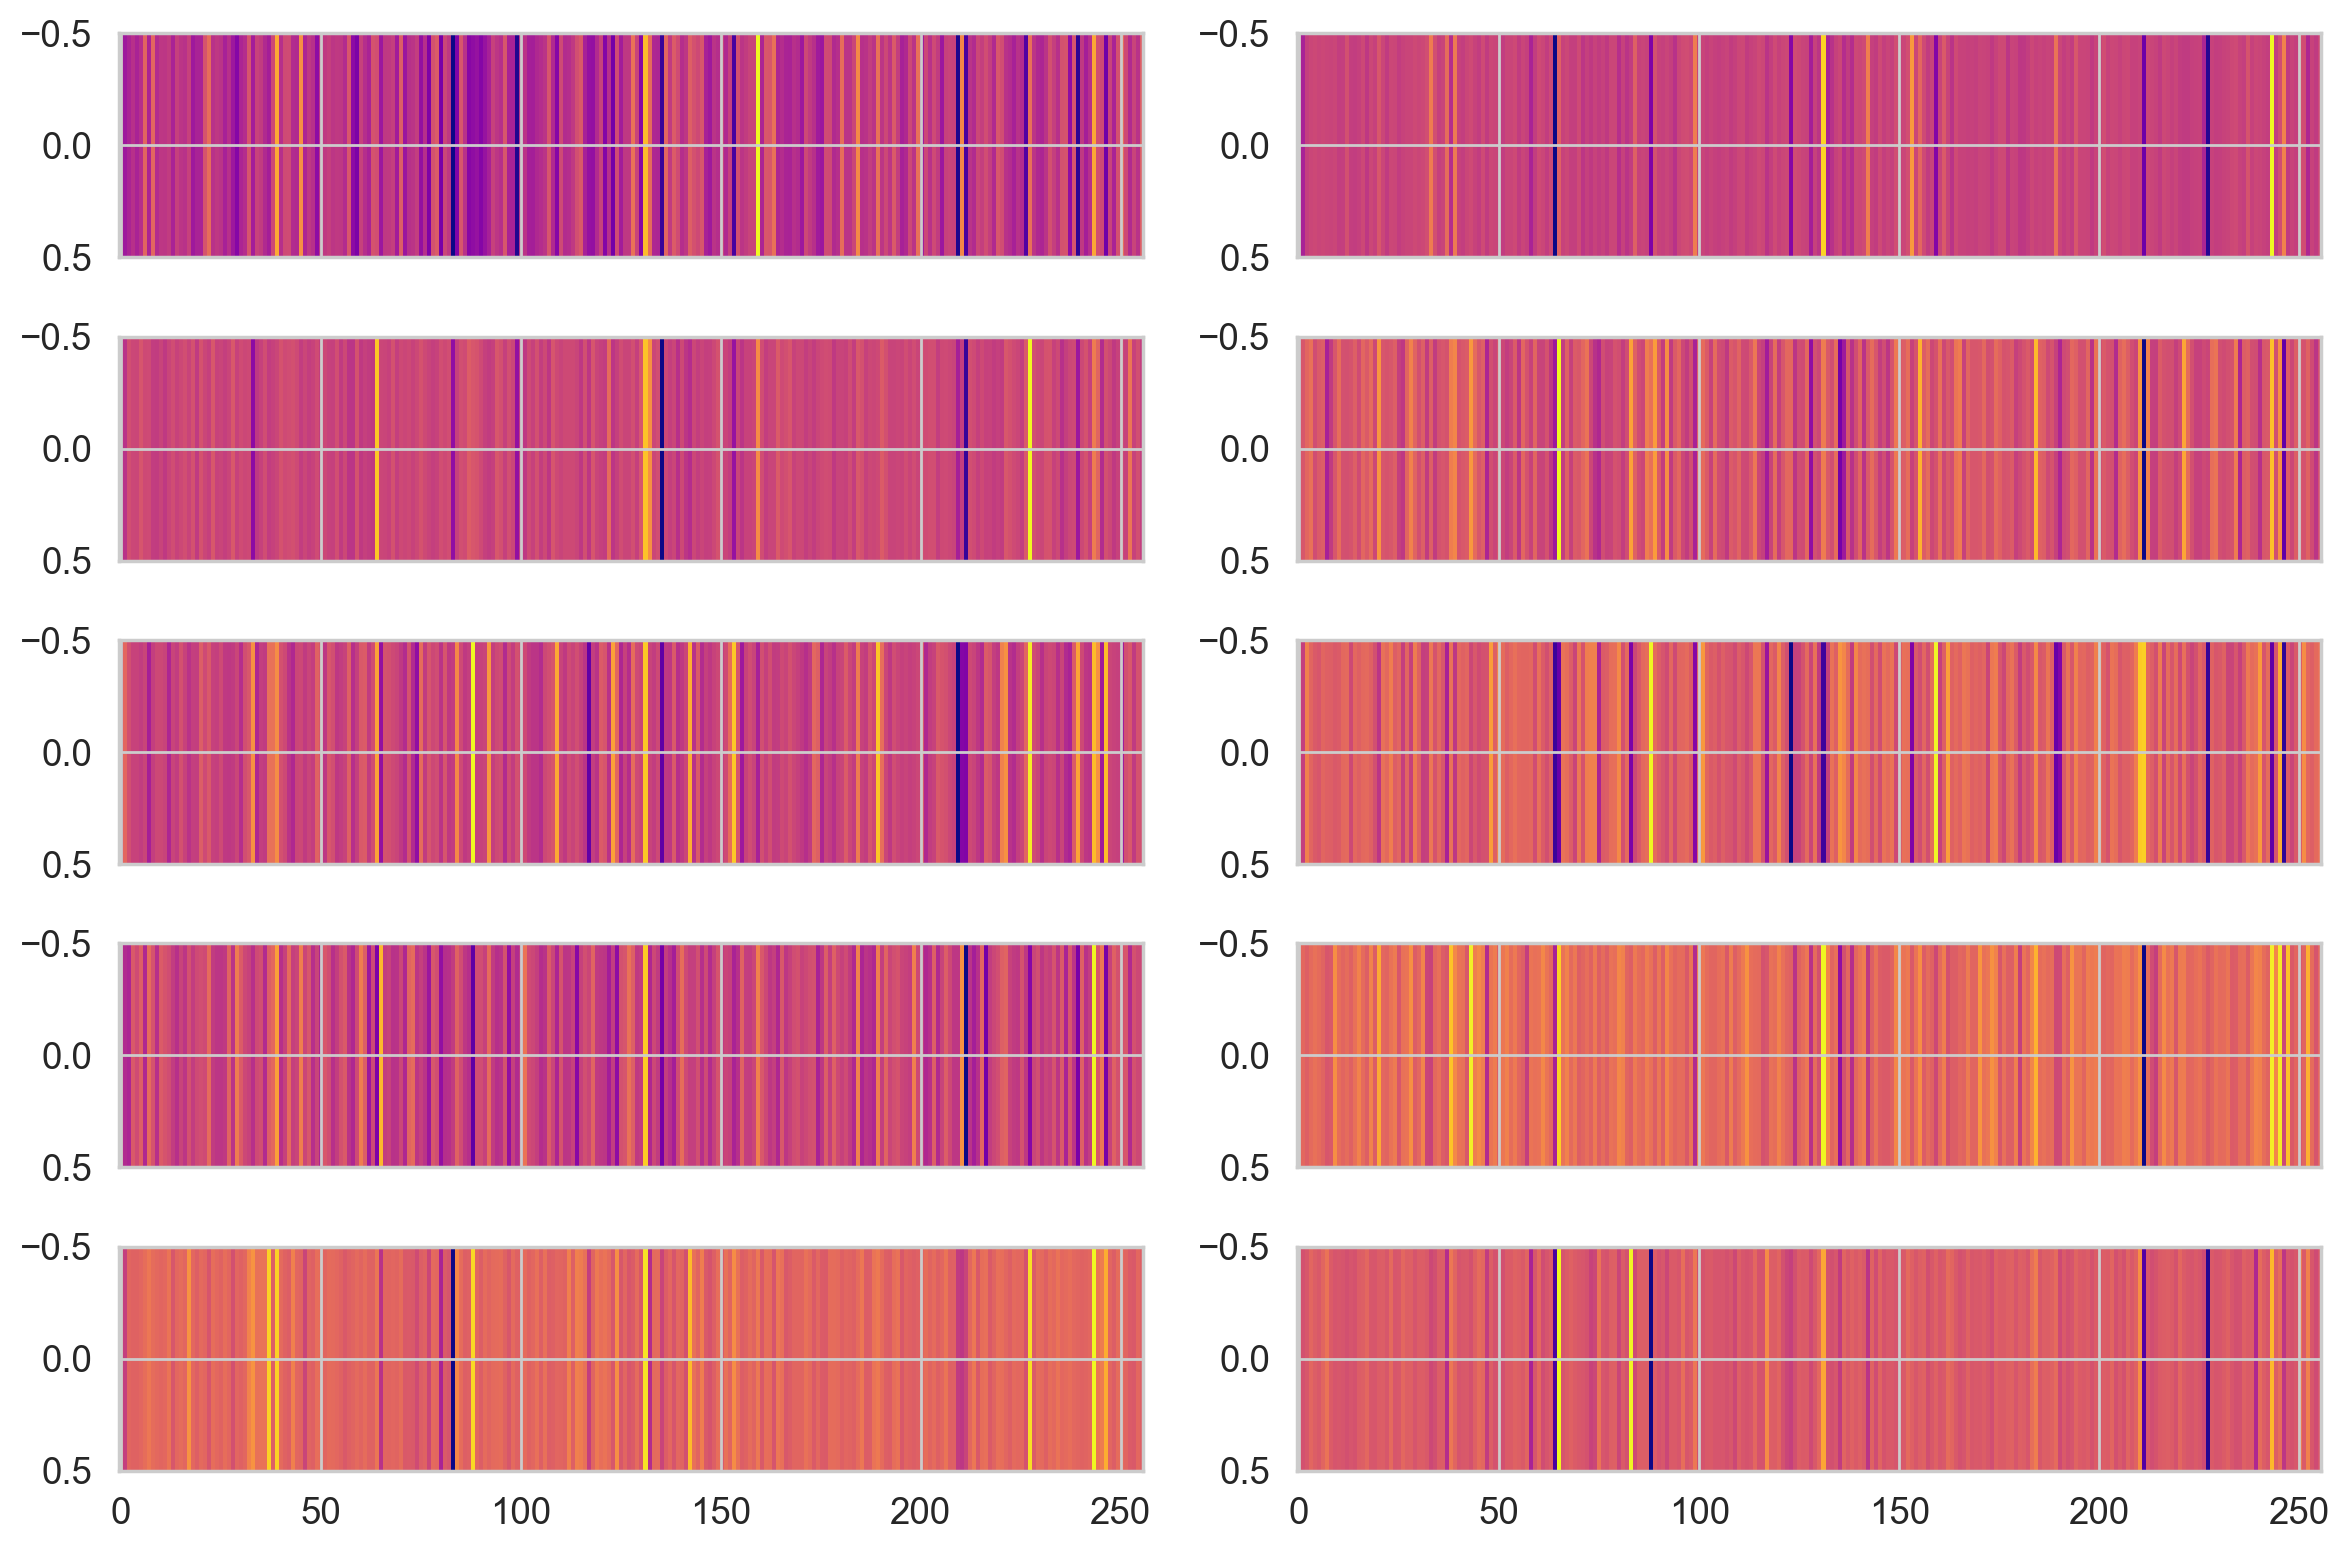

In [50]:
draw_heatmaps(embedding_list[16])

In [58]:
def gen_video_from_embeddings(embedding,model,save_file):
    seq_out = model.decoder(embedding.repeat(batch_size,1,1))
    gen_video(seq_out[0].detach().numpy(), save_file, 400, 400)

In [70]:
with torch.no_grad():
    for __id,(in_seq,tar_seq,action,vid_size) in tqdm(enumerate(test_dl)):
        in_seq = in_seq.to(device)
        tar_seq = tar_seq.to(device)
        seq_pred,embedding  = model(in_seq)

        for __id,(input_vid,output_vid,action) in enumerate(zip(in_seq.unbind(0),seq_pred.unbind(0),action.unbind(0))):
            os.makedirs(f"{test_vids}/{int(action)}",exist_ok=True)

            

        
            
        
        #embedding_list[]

SyntaxError: unexpected EOF while parsing (<ipython-input-70-ac52e3a33953>, line 12)

In [68]:
gen_video_from_embeddings(embedding_list[7][10],model,"embed_video.mp4")

In [64]:
test_emb = 0.5*embedding_list[19][0]+0.5*embedding_list[16][0]
gen_video_from_embeddings(test_emb,model,"test_embed_video.mp4")